In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam


#Librerías optimizacion por búsqueda aleatoria
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
maindf = pd.read_csv(r"/content/XAUUSD_D1.csv", sep="\t", parse_dates=["Time"], dayfirst=True)

In [ ]:
maindf['Time'] = pd.to_datetime(maindf['Time'], format='%Y-%m-%d')

maindf = maindf.loc[(maindf['Time'] >= '2006-12-31')
                     & (maindf['Time'] <= '2022-12-01')]


In [ ]:
# Separamos los valores de cierre
closedf = maindf[['Time','Close']]
print("Shape de closedf:", closedf.shape)

Shape de closedf: (4961, 2)


In [ ]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  4961


In [ ]:
del closedf['Time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(4961, 1)


In [ ]:
training_size=int(len(closedf)*0.75)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3720, 1)
test_data:  (1241, 1)


In [ ]:
# Convierte un array de valores en un matriz dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 3
train_X, train_y = create_dataset(train_data, time_step)
test_X, test_y = create_dataset(test_data, time_step)

print("X_train: ", train_X.shape)
print("y_train: ", train_y.shape)
print("X_test: ", test_X.shape)
print("y_test", test_y.shape)

X_train:  (3714, 5)
y_train:  (3714,)
X_test:  (1235, 5)
y_test (1235,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)

print("X_train: ", train_X.shape)
print("X_test: ", test_X.shape)

X_train:  (3714, 5, 1)
X_test:  (1235, 5, 1)


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.activations import tanh

def create_model(n_layers, n_neurons, dropout_rate, lr):
    model = Sequential()
    for i in range(n_layers):
        if i == 1:
            model.add(GRU(n_neurons, input_shape=train_X.shape[1:], return_sequences=True))
        else:
            model.add(GRU(n_neurons, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(GRU(n_neurons))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def objective(n_layers, dropout_rate, n_neurons, lr):
    n_layers = round(n_layers)
    n_neurons = round(n_neurons)
    model = create_model(n_layers, dropout_rate, n_neurons, lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    model.fit(train_X, train_y, epochs=100, validation_split=0.1, callbacks=[early_stop], verbose=0)
    loss = -model.evaluate(test_X, test_y, verbose=0)
    return loss

In [ ]:
# Definimos los límites de los hiperparámetros

param_dist = {
    'n_layers': sp_randint(1, 6),
    'n_neurons': sp_randint(32, 150),
    'dropout_rate': sp_uniform(loc=0.0, scale=0.99),
    'lr': sp_uniform(loc=1e-10, scale=1e-2)
}

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


<ipython-input-15-b904e0e7cb97>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


In [ ]:
import joblib
# Esto ejecuta la celda en varios núcleos de CPU
with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    random_search.fit(train_X, train_y)

39/39 [==============================] - 1s 4ms/step - loss: 9.6420e-04


39/39 [==============================] - 2s 4ms/step - loss: 8.3209e-05


39/39 [==============================] - 2s 6ms/step - loss: 0.0020


39/39 [==============================] - 2s 6ms/step - loss: 2.0938e-04


39/39 [==============================] - 2s 5ms/step - loss: 6.6323e-05


39/39 [==============================] - 2s 4ms/step - loss: 0.0264


39/39 [==============================] - 2s 5ms/step - loss: 3.6131e-04


39/39 [==============================] - 2s 4ms/step - loss: 1.0928e-04


39/39 [==============================] - 3s 5ms/step - loss: 0.0829


39/39 [==============================] - 3s 6ms/step - loss: 0.0327


39/39 [==============================] - 3s 6ms/step - loss: 2.0968e-04


39/39 [==============================] - 4s 8ms/step - loss: 0.0623


39/39 [==============================] - 4s 10ms/step - loss: 0.0052


39/39 [==============================] - 5s 10ms/step - loss: 0.0017


39/39 [==============================] - 3s 6ms/step - loss: 0.0831


39/39 [==============================] - 3s 6ms/step - loss: 0.0016


39/39 [==============================] - 1s 3ms/step - loss: 0.0097


39/39 [==============================] - 3s 5ms/step - loss: 4.0804e-04


39/39 [==============================] - 2s 4ms/step - loss: 4.2347e-04


39/39 [==============================] - 1s 3ms/step - loss: 6.4375e-05


39/39 [==============================] - 3s 5ms/step - loss: 0.0099


39/39 [==============================] - 2s 4ms/step - loss: 5.9754e-04


39/39 [==============================] - 2s 5ms/step - loss: 1.2949e-04


39/39 [==============================] - 2s 8ms/step - loss: 7.5915e-04


39/39 [==============================] - 3s 8ms/step - loss: 0.0014


39/39 [==============================] - 2s 8ms/step - loss: 1.9643e-04


39/39 [==============================] - 2s 8ms/step - loss: 0.0164


39/39 [==============================] - 2s 6ms/step - loss: 0.0012


39/39 [==============================] - 3s 6ms/step - loss: 5.8028e-04


39/39 [==============================] - 3s 7ms/step - loss: 3.9505e-04


39/39 [==============================] - 2s 8ms/step - loss: 3.0292e-04


39/39 [==============================] - 2s 7ms/step - loss: 4.4046e-04


39/39 [==============================] - 2s 6ms/step - loss: 0.0076


39/39 [==============================] - 2s 5ms/step - loss: 4.3581e-04


39/39 [==============================] - 2s 6ms/step - loss: 7.1825e-04


39/39 [==============================] - 2s 10ms/step - loss: 6.6659e-04


39/39 [==============================] - 2s 10ms/step - loss: 0.0013


53/78 [===================>..........] - ETA: 1s - loss: 0.0254

39/39 [==============================] - 2s 12ms/step - loss: 1.4752e-04


39/39 [==============================] - 1s 3ms/step - loss: 2.5804e-04


39/39 [==============================] - 1s 4ms/step - loss: 9.6481e-05


39/39 [==============================] - 2s 4ms/step - loss: 0.0297


39/39 [==============================] - 1s 4ms/step - loss: 0.0015


39/39 [==============================] - 2s 4ms/step - loss: 2.6547e-04


39/39 [==============================] - 3s 5ms/step - loss: 0.0399


39/39 [==============================] - 3s 6ms/step - loss: 4.9202e-04


23/78 [=======>......................] - ETA: 0s - loss: 0.0831

39/39 [==============================] - 2s 5ms/step - loss: 0.0237


39/39 [==============================] - 2s 5ms/step - loss: 8.5751e-04


39/39 [==============================] - 2s 5ms/step - loss: 8.2154e-05


65/78 [========================>.....] - ETA: 0s - loss: 0.0432

39/39 [==============================] - 2s 4ms/step - loss: 0.0671


39/39 [==============================] - 1s 4ms/step - loss: 0.0033


39/39 [==============================] - 1s 5ms/step - loss: 0.0806


39/39 [==============================] - 1s 5ms/step - loss: 0.0485


39/39 [==============================] - 2s 5ms/step - loss: 8.8498e-04


39/39 [==============================] - 1s 3ms/step - loss: 0.0174


39/39 [==============================] - 1s 2ms/step - loss: 1.6802e-04


117/117 [==============================] - 15s 21ms/step - loss: 0.0122


In [ ]:
print("Mejores parametros encontrados:", random_search.best_params_)
print("Mejor score encontrado:", random_search.best_score_)

Mejores parametros encontrados: {'dropout_rate': 0.07007565980189406, 'lr': 0.0017144131159741323, 'n_layers': 4, 'n_neurons': 111}
Mejor score encontrado: -0.0003794759201506774


In [ ]:
best_model_busq_aleatoria = create_model(int(random_search.best_params_['n_layers']),int(random_search.best_params_['n_neurons']),random_search.best_params_['dropout_rate'], random_search.best_params_['lr'])


In [ ]:

history = best_model_busq_aleatoria.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
117/117 [==============================] - 21s 84ms/step - loss: 0.0084 - val_loss: 5.5138e-04
Epoch 2/100
117/117 [==============================] - 7s 57ms/step - loss: 0.0011 - val_loss: 0.0078
Epoch 3/100
117/117 [==============================] - 7s 63ms/step - loss: 9.4002e-04 - val_loss: 4.8475e-04
Epoch 4/100
117/117 [==============================] - 7s 62ms/step - loss: 8.0178e-04 - val_loss: 7.9983e-04
Epoch 5/100
117/117 [==============================] - 7s 57ms/step - loss: 8.5299e-04 - val_loss: 7.9083e-04
Epoch 6/100
117/117 [==============================] - 8s 64ms/step - loss: 7.3753e-04 - val_loss: 0.0021
Epoch 7/100
117/117 [==============================] - 6s 55ms/step - loss: 6.7027e-04 - val_loss: 8.3840e-04
Epoch 8/100
117/117 [==============================] - 7s 64ms/step - loss: 6.9292e-04 - val_loss: 0.0023
Epoch 9/100
117/117 [==============================] - 6s 55ms/step - loss: 6.9501e-04 - val_loss: 0.0048
Epoch 10/100
117/117 [===========

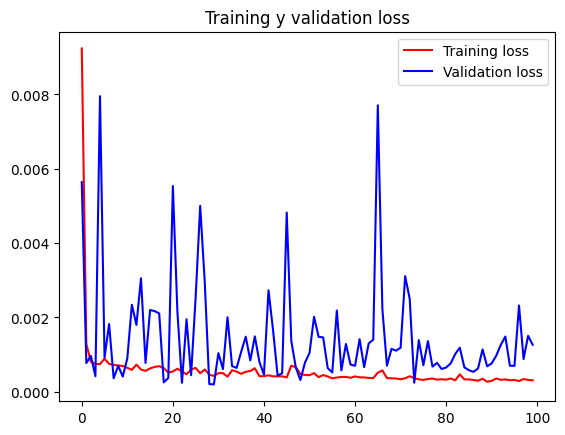

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training y validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=best_model_busq_aleatoria.predict(train_X)
test_predict=best_model_busq_aleatoria.predict(test_X)
train_predict.shape, test_predict.shape

39/39 [==============================] - 1s 13ms/step


((3714, 1), (1235, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Evaluation metrices RMSE, MAE and MAPE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MAPE: ", mape(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MAPE: ", mape(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  21.707714640270055
Train data MAPE:  1.5197819145240785
Train data MAE:  16.62305974174997
-------------------------------------------------------------------------------------
Test data RMSE:  51.88979795550543
Test data MAPE:  2.124106772441288
Test data MAE:  38.23460566485324


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original','Precio predicho Train','Precio predicho Test'])


plotdf = pd.DataFrame({'date': close_stock['Time'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Precio (USD)','date': 'Fecha'})
fig.update_layout(title_text='Comparación entre precio original de cierre y precio predic de cierre',
                  plot_bgcolor='white', font_size=14, font_color='black', legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4961, 1)
Test predicted data:  (4961, 1)
